<a href="https://colab.research.google.com/github/hakim3189/MachineLearning/blob/main/Submission_Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Animal Faces
- **Nama:** Muhammad Rheza Iwanul Hakim
- **Email:** rheza.hakim.89@gmail.com
- **ID Dicoding:** rheza89

## Import Semua Packages/Library yang Digunakan

In [1]:
# Most Used Library
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
# Libraries for Image Processing
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt
import seaborn as sns # This line imports the seaborn library and assigns it to the alias 'sns'
# Libraries for Build Model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau


import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhezahakim","key":"7d59da0af5d9999d1abcb09deec1950d"}'}

In [4]:
!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train

In [5]:
import os
import shutil

In [6]:
# Direktori awal untuk train dan test
train_dir = "afhq/train"
test_dir = "afhq/val"

# Direktori baru untuk dataset gabungan
combined_dir = "afhq/dataset"

In [7]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [8]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

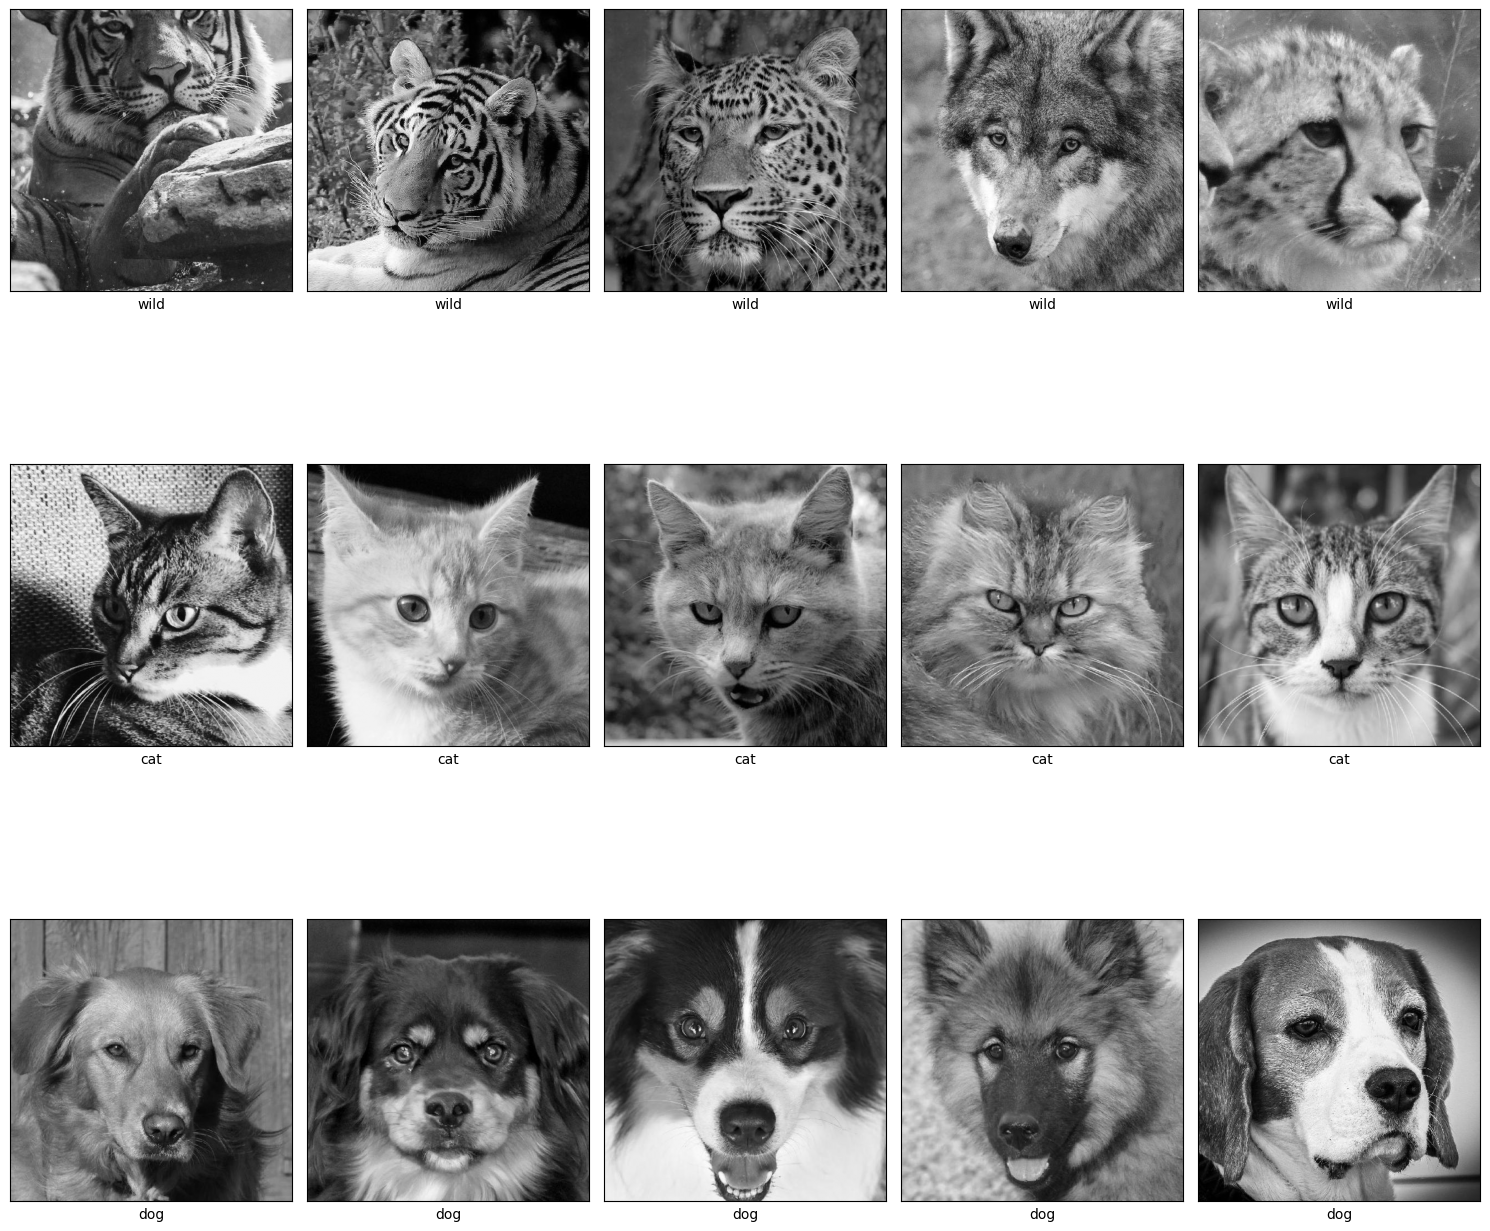

In [9]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_faces_image = {}

# Tentukan path sumber train
path = "afhq/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    animal_faces_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "afhq/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(animal_faces_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_faces_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

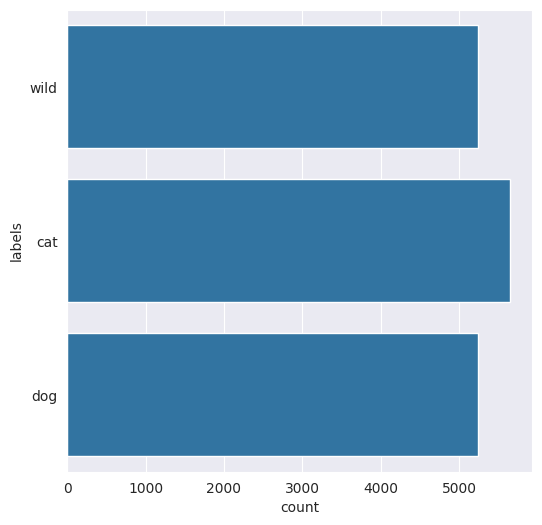

In [10]:
# Definisikan path sumber
lung_path = "afhq/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [11]:
mypath= 'afhq/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
cat,5653
dog,5239
wild,5238


In [12]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=200)

In [13]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "afhq/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
test   cat       1139
       dog       1024
       wild      1063
train  cat       4514
       dog       4215
       wild      4175
dtype: int64 


                                           path labels    set
0      afhq/dataset/wild/flickr_wild_000038.jpg   wild  train
8222    afhq/dataset/cat/pixabay_cat_004596.jpg    cat  train
10433  afhq/dataset/wild/flickr_wild_000521.jpg   wild  train
9614     afhq/dataset/cat/flickr_cat_000331.jpg    cat  train
6748    afhq/dataset/cat/pixabay_cat_004770.jpg    cat  train


In [15]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [16]:
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_cat = os.path.join(TRAIN_DIR + '/cat')
train_dog = os.path.join(TRAIN_DIR + '/dog')
train_wild = os.path.join(TRAIN_DIR + '/wild')
test_cat = os.path.join(TEST_DIR + '/cat')
test_dog = os.path.join(TEST_DIR + '/dog')
test_wild = os.path.join(TEST_DIR + '/wild')

print("Total number of cat images in training set: ",len(os.listdir(train_cat)))
print("Total number of dog images in training set: ",len(os.listdir(train_dog)))
print("Total number of wild images in training set: ",len(os.listdir(train_wild)))
print("Total number of cat images in test set: ",len(os.listdir(test_cat)))
print("Total number of dog images in test set: ",len(os.listdir(test_dog)))
print("Total number of wild images in test set: ",len(os.listdir(test_wild)))

Total number of cat images in training set:  4514
Total number of dog images in training set:  4215
Total number of wild images in training set:  4175
Total number of cat images in test set:  1139
Total number of dog images in test set:  1024
Total number of wild images in test set:  1063


In [17]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2,
                             rotation_range=20,  # Rotate images by up to 20 degrees
                             width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
                             height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
                             shear_range=0.2,  # Apply shear transformations
                             zoom_range=0.3,  # Zoom in or out on images
                             horizontal_flip=True  # Flip images horizontally
                             )
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 10324 images belonging to 3 classes.
Found 2580 images belonging to 3 classes.
Found 3226 images belonging to 3 classes.


## Modelling

In [18]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_test = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_test.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_test.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_test.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2)))

# Flatten layer
model_test.add(Flatten())
# 1nd Dense Layer
model_test.add(Dense(256, activation = 'relu'))
# 1nd Dropout Layer
model_test.add(Dropout(0.5))
# 2nd Dense Layer
model_test.add(Dense(128, activation = 'relu'))
# 2nd Dropout Layer
model_test.add(Dropout(0.3))
# 3nd Dense Layer
model_test.add(Dense(64, activation = 'relu'))

# Final Dense layer
model_test.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the Model Architecture
print(model_test.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,139 (10.54 MB)

 Trainable params: 2,762,947 (10.54 MB)

 Non-trainable params: 192 (768.00 B)

None


In [19]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
train_cat = os.path.join(TRAIN_DIR + '/cat')
train_dog = os.path.join(TRAIN_DIR + '/dog')
train_wild = os.path.join(TRAIN_DIR + '/wild')

# Calculate class weights for three classes
count_cat, count_dog, count_wild = len(os.listdir(train_cat)), len(os.listdir(train_dog)), len(os.listdir(train_wild))
total_samples = count_cat + count_dog + count_wild

weight_cat = (1 / count_cat) * (total_samples) / 3.0
weight_dog = (1 / count_dog) * (total_samples) / 3.0
weight_wild = (1 / count_wild) * (total_samples) / 3.0

class_weights = {0: weight_cat, 1: weight_dog, 2: weight_wild}  # Assuming 0:cat, 1:dog, 2:wild

# Fitting / training model
history_1 = model_test.fit(train_generator,
                        epochs=40,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4263 - loss: 1.5988

323/323 ━━━━━━━━━━━━━━━━━━━━ 78s 205ms/step - accuracy: 0.4265 - loss: 1.5977 - val_accuracy: 0.4984 - val_loss: 0.9825
Epoch 2/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6147 - loss: 0.8318

323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 172ms/step - accuracy: 0.6148 - loss: 0.8317 - val_accuracy: 0.6853 - val_loss: 0.7438
Epoch 3/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.7460 - loss: 0.6027 - val_accuracy: 0.6829 - val_loss: 0.8185
Epoch 4/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8249 - loss: 0.4410

323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 169ms/step - accuracy: 0.8250 - loss: 0.4408 - val_accuracy: 0.7764 - val_loss: 0.5531
Epoch 5/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.8887 - loss: 0.3039 - val_accuracy: 0.5275 - val_loss: 1.2881
Epoch 6/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9129 - loss: 0.2385

323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.9129 - loss: 0.2385 - val_accuracy: 0.8380 - val_loss: 0.3743
Epoch 7/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9338 - loss: 0.1927

323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 171ms/step - accuracy: 0.9338 - loss: 0.1927 - val_accuracy: 0.8988 - val_loss: 0.2757
Epoch 8/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9352 - loss: 0.1802

323/323 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9352 - loss: 0.1802 - val_accuracy: 0.9143 - val_loss: 0.2477
Epoch 9/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9417 - loss: 0.1699

323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9417 - loss: 0.1699 - val_accuracy: 0.9260 - val_loss: 0.2067
Epoch 10/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9512 - loss: 0.1478 - val_accuracy: 0.8795 - val_loss: 0.3203
Epoch 11/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 83s 173ms/step - accuracy: 0.9473 - loss: 0.1517 - val_accuracy: 0.8500 - val_loss: 0.4184
Epoch 12/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9470 - loss: 0.1551

323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 166ms/step - accuracy: 0.9470 - loss: 0.1551 - val_accuracy: 0.9233 - val_loss: 0.2028
Epoch 13/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.9500 - loss: 0.1488 - val_accuracy: 0.9213 - val_loss: 0.2059
Epoch 14/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 166ms/step - accuracy: 0.9545 - loss: 0.1386 - val_accuracy: 0.9159 - val_loss: 0.2561
Epoch 15/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 55s 172ms/step - accuracy: 0.9599 - loss: 0.1224 - val_accuracy: 0.8806 - val_loss: 0.3555
Epoch 16/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 166ms/step - accuracy: 0.9618 - loss: 0.1177 - val_accuracy: 0.9140 - val_loss: 0.2113
Epoch 17/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9666 - loss: 0.1065

323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.9666 - loss: 0.1065 - val_accuracy: 0.9244 - val_loss: 0.2002
Epoch 18/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 56s 172ms/step - accuracy: 0.9585 - loss: 0.1201 - val_accuracy: 0.8787 - val_loss: 0.2865
Epoch 19/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.9610 - loss: 0.1161 - val_accuracy: 0.9124 - val_loss: 0.2393
Epoch 20/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.9640 - loss: 0.1051 - val_accuracy: 0.8426 - val_loss: 0.4112
Epoch 21/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.9628 - loss: 0.1125 - val_accuracy: 0.9116 - val_loss: 0.2405
Epoch 22/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 65s 203ms/step - accuracy: 0.9668 - loss: 0.1012 - val_accuracy: 0.9190 - val_loss: 0.2305
Epoch 23/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9683 - loss: 0.0884

323/323 ━━━━━━━━━━━━━━━━━━━━ 67s 207ms/step - accuracy: 0.9683 - loss: 0.0884 - val_accuracy: 0.9302 - val_loss: 0.1850
Epoch 24/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.9685 - loss: 0.0936 - val_accuracy: 0.9221 - val_loss: 0.2303
Epoch 25/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9705 - loss: 0.0834

323/323 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.9704 - loss: 0.0834 - val_accuracy: 0.9562 - val_loss: 0.1252
Epoch 26/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 58s 179ms/step - accuracy: 0.9696 - loss: 0.0950 - val_accuracy: 0.9078 - val_loss: 0.2157
Epoch 27/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 77s 165ms/step - accuracy: 0.9700 - loss: 0.0916 - val_accuracy: 0.9190 - val_loss: 0.2357
Epoch 28/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 53s 164ms/step - accuracy: 0.9673 - loss: 0.0956 - val_accuracy: 0.9085 - val_loss: 0.2077
Epoch 29/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 54s 167ms/step - accuracy: 0.9744 - loss: 0.0748 - val_accuracy: 0.9132 - val_loss: 0.1898
Epoch 30/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.9765 - loss: 0.0745 - val_accuracy: 0.9469 - val_loss: 0.1598
Epoch 31/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 52s 161ms/step - accuracy: 0.9718 - loss: 0.1073 - val_accuracy: 0.9504 - val_loss: 0.1287
Epoch 32/40
323/323 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step - accuracy: 0.9705 - loss: 0.085

## Evaluasi dan Visualisasi

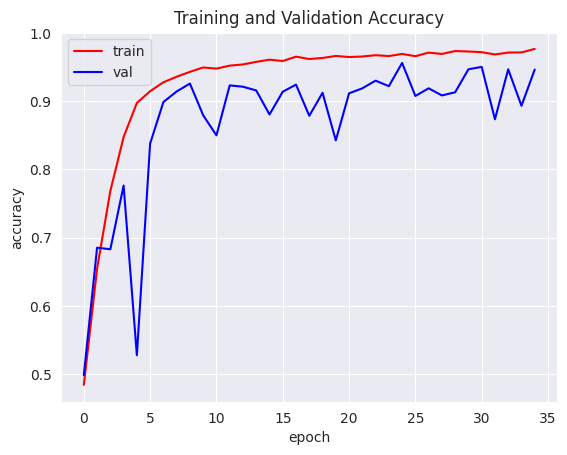

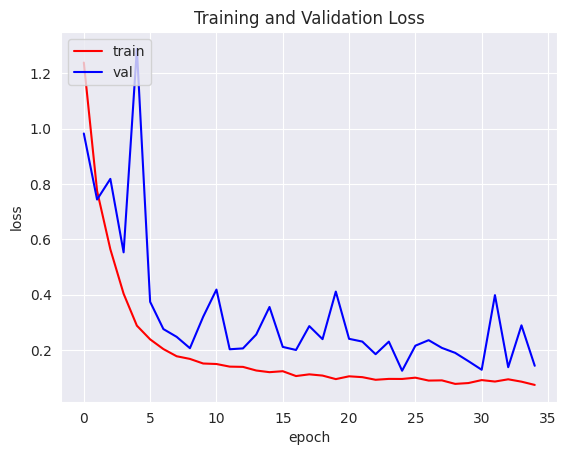

In [21]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [22]:
# model_test.save("model.h5")
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
2025-02-09 14:39:39.031101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739111979.052689   10246 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739111979.059003   10246 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS w

In [34]:
export_dir = 'saved_model/'
tf.saved_model.save(model_test, export_dir)

# Convert SavedModel menjadi model.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

17204

In [35]:
from PIL import Image
import os

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(combined_dir)

wild: 5238
- (512, 512)
---------------
cat: 5653
- (512, 512)
---------------
dog: 5239
- (512, 512)
---------------

Total: 16130


## Inference (Optional)

In [37]:
# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

def predict_image(image_path):
    # Use tf.keras.utils.load_img instead of image.load_img
    img = tf.keras.utils.load_img(image_path, target_size=(150, 150), color_mode="grayscale")
    img_array = tf.keras.utils.img_to_array(img)  # Use tf.keras.utils.img_to_array
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    class_labels = {0: 'cat', 1: 'dog', 2: 'wild'} # Replace with your actual class labels
    predicted_label = class_labels.get(predicted_class, "Unknown")

    return predicted_label, prediction


# Example usage
image_path = "New_Cat_Data.jpg" # Replace with the path to your image
predicted_label, prediction = predict_image(image_path)
print(f"Predicted label: {predicted_label}")
print(f"Prediction probabilities: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
Predicted label: cat
Prediction probabilities: [[1.000000e+00 3.445336e-17 2.677507e-15]]


In [38]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.3
ale-py==0.10.1
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.0
astropy-iers-data==0.2025.2.3.0.32.42
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
bigframes==1.34.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.3.1
cr